In [1]:
import imageio
import glob
import re
from random import sample, seed
import os
import matplotlib.pyplot as plt
import numpy as np
from math import *
import pptk
import sys
import cv2
import os

In [2]:
seed(20)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [3]:
# This function will read a series of PNG file and convert its content to a 3d  array containing the volume, 
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        padding: If set to an interger x, then each png image will be copied x times and these slices will all be added
#               to the volume. This is used to pad between the slices.
# Return: a 3d numpy array representing the volume containing the stack of the png images and their copies.

def ReadPointFromPNG(filepath, padding:int):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now concatinate them into a single 3D array")
    imageData = []
    
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        
        for i in range(padding):
            imageData.append(image)
            
    imageData = np.asarray(imageData)
    imageData = np.rot90(imageData, 1, (0, 2))
    imageData = np.rot90(imageData, 1, (1, 0))
    print("Done!")
    return imageData

In [4]:
# Given a 3d volume, a plane's parameter (a,b,c,d as in ax + by + cz + d = 0) and the center point coordinate (must be on
# the plane specified), return the image correspond to the plane, centered at the certer point's location
# Param: data_volume: a 3d numpy array containing the volume data
#        planeParam: parameters of a plane (a,b,c,d as in ax + by + cz + d = 0)
#        centerPoint: the 3d coordinate of a point. The point has to be on the plane. The result image will be centered
#                     by this point. 
#        range: how large the result image will be. The larger the image, the slower the computation

def getTangentPlane (data_volume, planeParam, centerPoint, resultRange: int = 100):
    
    a, b, c, d = planeParam
    
    if(a * centerPoint[0] + b * centerPoint[1] + c * centerPoint[2] + d != 0):
        print("error: center point is not on the plane!")
        return
    
    data_volume = np.asarray(data_volume)
    bounds = data_volume.shape

    if( a == 0 and b !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([0, -d/b , 0])
        u = u / np.linalg.norm(u)
    elif( b == 0 and a !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif( c == 0 and a !=0 and b != 0):
        u = np.array([0, -d/b, 0]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif(a == 0 and b == 0):
        u = np.array([1, 0, 0])
    elif(a == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(b == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(a == 0 or b == 0 or c == 0):
        print("plane parameter error! a =", a, "b =", b, "c =", c, "d =", d)
    else:
        u = np.array([0, 0, -d/c]) - np.array([1, 1, (-d - a - b)/c])
        u = u / np.linalg.norm(u)
         
    normal = np.array([a, b, c])
    normal = normal / np.linalg.norm(normal)
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    
    halfDiagnalLength = resultRange
    planeImg = np.zeros((halfDiagnalLength*2, halfDiagnalLength*2))
    
    # filling the 2d Image, this part can be further optimized by using matrix
    for x in range(-halfDiagnalLength, halfDiagnalLength):
        for y in range(-halfDiagnalLength, halfDiagnalLength):
            vectorElem1 = x*u
            vectorElem2 = y*v
            volumeCor = vectorElem1 + vectorElem2 + centerPoint
            #Check boundary
            if(volumeCor[0] > 0 and volumeCor[0] < bounds[0] and volumeCor[1] > 0 and volumeCor[1] < bounds[1] and\
              volumeCor[2] > 0 and volumeCor[2] < bounds[2]):
                volxelVal = data_volume[floor(volumeCor[0])][floor(volumeCor[1])][floor(volumeCor[2])]
                planeImg[x + halfDiagnalLength][y + halfDiagnalLength] = volxelVal
        
    return planeImg

In [5]:
filePath = 'mri_image_2016/*.png'
data = ReadPointFromPNG(filePath, 2)

---------------
Begin reading points data from PNG files
There are 144 PNG files, now concatinate them into a single 3D array
Done!


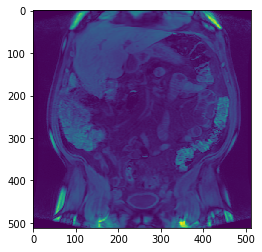

In [6]:
plt.imshow(data[:, :, 100])

In [7]:
plane = 0.05, -0.05, 1, -100
center = np.array([250, 250, 100])

In [8]:
result = getTangentPlane (data, plane, center)

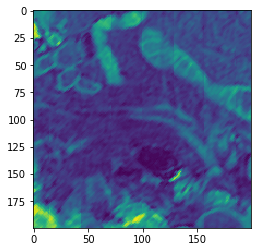

In [9]:
plt.imshow(result)

In [10]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)
    
def expand_centerline_coord(centerline_array):
    new_array = []
    for p in centerline_array:
        x = p[0] * 2
        y = p[1] 
        z = p[2] * 2
        point = [x,y,z]
        new_array.append(point)
        
    new_array = np.array(new_array)
    
    return new_array

In [11]:
centerline_array = np.load("centerlineInorder.npy")
print(centerline_array.shape)

# centerline_array = expand_centerline_coord(centerline_array)
# displayPoints(centerline_array, 1.3)
centerline_array

(313, 3)


array([[448.22673329, 277.17925917, 144.57358302],
       [446.70286083, 269.73505532, 148.55835414],
       [432.9913066 , 251.32054129, 149.47986925],
       [419.98537681, 255.40583935, 160.12066536],
       [407.88573249, 237.35386629, 161.29996806],
       [401.9197059 , 234.62987872, 160.84074589],
       [395.9640457 , 245.51962234, 154.61757679],
       [390.73600671, 258.04903398, 155.8840116 ],
       [391.86251542, 259.43709836, 156.03562393],
       [393.55551581, 266.48933363, 157.03841568],
       [396.24855487, 268.80971661, 154.43977679],
       [398.79214518, 269.02598021, 154.28452695],
       [399.04313967, 271.33892584, 154.5050765 ],
       [396.54069925, 276.45415349, 154.43530494],
       [393.26735319, 278.34556825, 155.01331738],
       [391.17766427, 283.80679707, 155.62921581],
       [387.8903325 , 288.64739966, 155.78791226],
       [392.95857304, 292.94464831, 157.14476584],
       [390.8255915 , 296.49924019, 157.62191648],
       [387.47355241, 301.89939

In [12]:
def VectorBetweenTwoPoints(p1, p2):
    return p2 - p1

def GetPlaneParam(p, n):
    a = n[0]
    b = n[1]
    c = n[2]
    d = - (n[0]*p[0] + n[1]*p[1] + n[2]*p[2])
    return (a,b,c,d)

def AssertSameVector(v1, v2):
    assert len(v1) == len(v2)
    for i in range (len(v1)):
        assert v1[i] == v2[i]
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [13]:
def CollectPlanePointPair(centerline_points):
    plane_point_pairs = []
    
    i = 0
    for p in centerline_points:
        AssertSameVector(p, centerline_points[i])

        tangent = (0,0,0)
        if i - 1 >= 0 and i + 1 < len(centerline_points):
            tangent = VectorBetweenTwoPoints(centerline_points[i - 1], centerline_points[i + 1])
        elif i - 1 >= 0:
            tangent = VectorBetweenTwoPoints(centerline_points[i - 1], p)
        elif i + 1 < len(centerline_points):
            tangent = VectorBetweenTwoPoints(p, centerline_points[i+1])
        else:
            print ("seems that the list has only one or no element.")
            print ("the actual element num is:", len(centerline_points))
            break
            
        n = normalize(tangent)
        
        plane_param = GetPlaneParam(p,n)
        plane_point_pairs.append((plane_param, p))
        
        i += 1
        
    return plane_point_pairs

In [14]:
centerline_points = centerline_array
plane_point_pairs = CollectPlanePointPair(centerline_points)

In [15]:
def CollectResultImages(plane_point_pairs):
    results = []
    sys.stdout.write("Progress: [")
    sys.stdout.flush()
    os.system("mkdir ./Images")
    for i in range(len(plane_point_pairs)):
        plane = plane_point_pairs[i][0]
        center = plane_point_pairs[i][1]
        result = getTangentPlane (data, plane, center)
        results.append(result)
        filename = "Images/" + str(i) + ".png"
        plt.imsave(filename,result)
        
        if i % 10 == 0:
            sys.stdout.write("=")
            sys.stdout.flush()
    
    sys.stdout.write("]\n")
    sys.stdout.flush()
    print ("[ Done! We have", len(results), "images", "Saved to the folder called Images.")
    return results

In [16]:
result_images = CollectResultImages(plane_point_pairs[:5])

Progress: [=]
[ Done! We have 5 images Saved to the folder called Images.


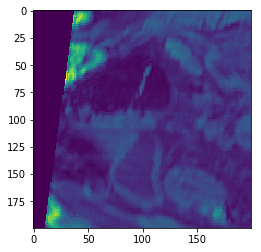

In [20]:
plt.imshow(result_images[1])

In [18]:
def MakeMovieOutOfImage():
    image_folder = 'Images'
    video_name = 'video.avi'
    
    image_name_list = os.listdir(image_folder)
    image_name_list.sort()
    images = [img for img in image_name_list if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 2, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [19]:
MakeMovieOutOfImage()